In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sentence_transformers import SentenceTransformer
from pandas import DataFrame
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.cluster import KMeans

## Handcrafted vectors

In [2]:
handcrafted_vectors = {
    "queen": {
        'kingdom': 1.0,
        'male': 0,
        'is_human': 1,
        'is_animal': 0,
        'is_fictional': 0,
        'size': 0.9
    },
    "king": {
        'kingdom': 1.0,
        'male': 1,
        'is_human': 1,
        'is_animal': 0,
        'is_fictional': 0,
        'size': 1
    },
    "cat": {
        'kingdom': 0,
        'male': 0.5,
        'is_human': 0,
        'is_animal': 1,
        'is_fictional': 0,
        'size': 0.2
    },
    "dog": {
        'kingdom': 0,
        'male': 0.5,
        'is_human': 0,
        'is_animal': 1,
        'is_fictional': 0,
        'size': 0.5
    },
    "lion_king": {
        'kingdom': 1.0,
        'male': 1,
        'is_human': 0,
        'is_animal': 1,
        'is_fictional': 1,
        'size': 0.9
    },
    "castle": {
        'kingdom': 1.0,
        'male': 0,
        'is_human': 0,
        'is_animal': 0,
        'is_fictional': 0,
        'size': 2
    }
}
my_6_words = list(handcrafted_vectors.keys())
my_6_words


['queen', 'king', 'cat', 'dog', 'lion_king', 'castle']

## Semantic space itself

In [3]:
df = pd.DataFrame(handcrafted_vectors.values(), index=my_6_words)
df

,kingdom,male,is_human,is_animal,is_fictional,size
queen,1.0,0.0,1,0,0,0.9
king,1.0,1.0,1,0,0,1.0
cat,0.0,0.5,0,1,0,0.2
dog,0.0,0.5,0,1,0,0.5
lion_king,1.0,1.0,0,1,1,0.9
castle,1.0,0.0,0,0,0,2.0


## Let's simplify the space a little bit

![Tux, the Linux mascot](./data/pca.gif)

In [4]:
pca = PCA(n_components=2)
space_2d = DataFrame(pca.fit_transform(df), index=df.index, columns=['x', 'y'])
space_2d

,x,y
queen,-0.761380,-0.556288
king,-0.629010,-0.233840
cat,1.084759,-0.363504
dog,0.920335,-0.234906
lion_king,0.422721,1.013853
castle,-1.037424,0.374683


## Show me that space!

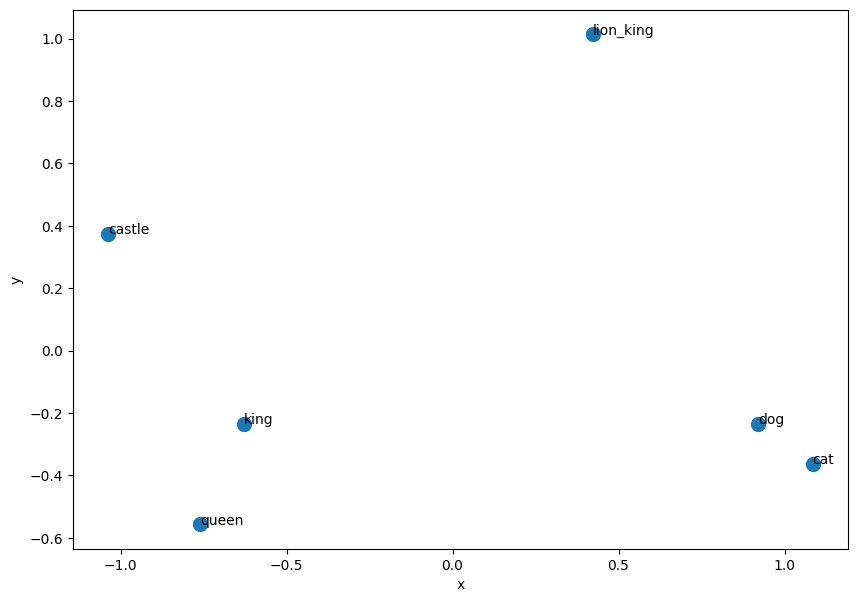

In [5]:
space_2d.plot(kind='scatter', x='x', y='y', figsize=(10, 7), s=100)
for i, txt in enumerate(space_2d.index):
    plt.annotate(txt, (space_2d['x'].iloc[i], space_2d['y'].iloc[i]))   

## Now with the help of SentenceTransformer neural network

In [6]:
model = SentenceTransformer('all-mpnet-base-v2')
vectors = model.encode(my_6_words)
vectors

array([[ 1.6129452e-03,  7.9590306e-03, -4.8747123e-03, ...,
        -1.5866318e-03, -4.5408778e-02,  8.1609199e-03],
       [ 3.0709039e-02,  2.3857193e-02, -6.5478867e-05, ...,
        -3.5208671e-03, -3.4867179e-02,  6.0758763e-03],
       [ 2.6498312e-02,  5.7731919e-02, -2.6925063e-02, ...,
         3.1392116e-02,  1.7102713e-02, -2.0599846e-02],
       [ 2.1568064e-02,  4.3196801e-02, -2.1951020e-02, ...,
         2.0175826e-02, -3.4934897e-02, -1.5062163e-02],
       [ 8.8965252e-02,  6.3524805e-02,  7.4319984e-03, ...,
         1.5193290e-02, -1.7881179e-02,  1.5813131e-02],
       [-2.2170974e-03,  8.3502270e-02, -3.8393843e-03, ...,
        -1.9128218e-02,  7.5290641e-03, -8.3199274e-03]], dtype=float32)

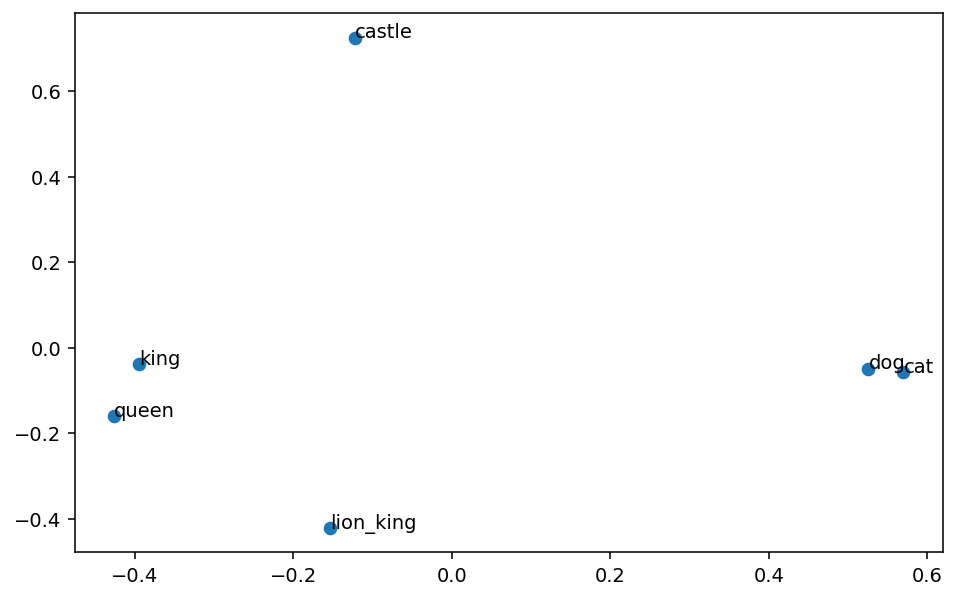

In [7]:
pca = PCA(n_components=2)
space_2d = DataFrame(pca.fit_transform(vectors), index=my_6_words, columns=['x', 'y'])
plt.figure(figsize=(8, 5), dpi=140)
plt.scatter(space_2d['x'], space_2d['y'])
for i, txt in enumerate(space_2d.index):
    plt.annotate(txt, (space_2d['x'].iloc[i], space_2d['y'].iloc[i]))
plt.show()

## Use cases

1. Similarity search
2. Clustering
3. Classification
4. Meaning extraction
5. Anomaly detection
6. Document ranking
7. Data visualization
8. Semantic analysis

# Let's go real!

In [8]:
animals = pd.read_parquet('data/animals.parquet').reset_index(drop=True)
animals

,Animal
0,Canidae
1,Felidae
2,Cat
3,Cattle
4,Dog
...,...
489,Sheep
490,Siamese fighting fish
491,Society finch
492,Yak


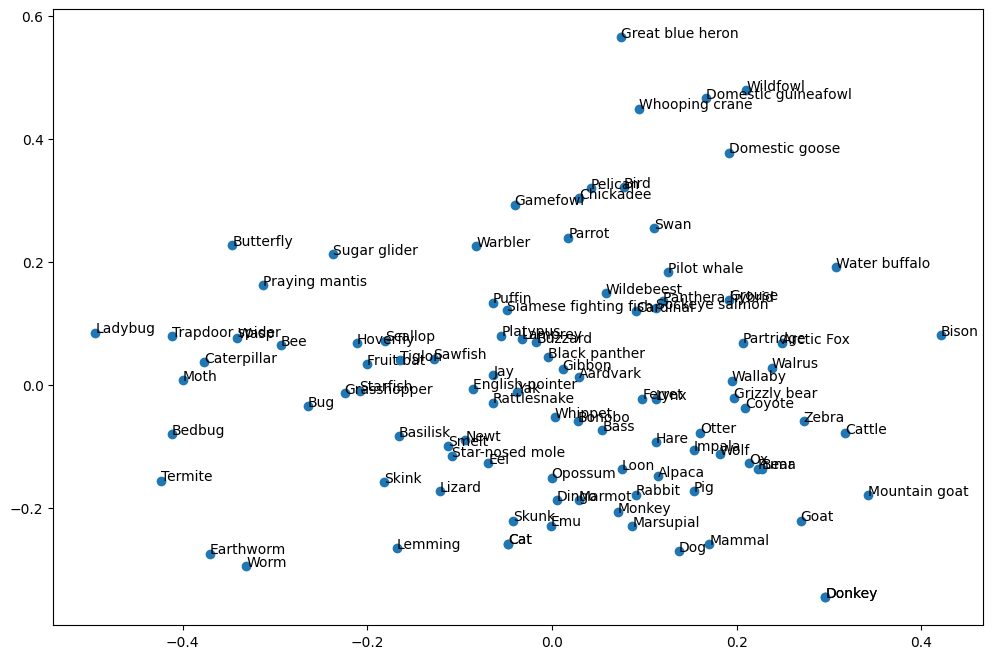

In [9]:
animals_sample = animals.sample(100).reset_index()
animals_vectors = model.encode(animals_sample['Animal'])
pca = PCA(n_components=2)
animals_space_2d = DataFrame(pca.fit_transform(animals_vectors), index=animals_sample['Animal'], columns=['x', 'y'])
plt.figure(figsize=(12, 8), dpi=100)
plt.scatter(animals_space_2d['x'], animals_space_2d['y'])
for i, txt in enumerate(animals_space_2d.index):
    plt.annotate(txt, (animals_space_2d['x'].iloc[i], animals_space_2d['y'].iloc[i]))

## Similarity search

![Tux, the Linux mascot](./data/euclidean_distance-1024x930.png)

![Tux, the Linux mascot](./data/similarity-1024x464.png)

In [10]:
def similarity_search(query: str, v: list, index: list, top: int = 5) -> DataFrame:
    query_vector = model.encode([query])
    _similarities = cosine_similarity(query_vector, v)[0]
    _top_indices = _similarities.argsort()[-top:][::-1]
    return DataFrame({'index': [index[idx] for idx in _top_indices], 'similarity': _similarities[_top_indices]})

In [11]:
birds = similarity_search('birds', animals_vectors, animals['Animal'], 50)
birds['similarity'].astype(float)
birds['distance'] =  np.clip(1.0 - birds['similarity'], 0, None)
birds

,index,similarity,distance
0,Fancy rat varieties,0.676056,0.323944
1,Buzzard,0.557526,0.442474
2,Cephalopod,0.548795,0.451205
3,Bass,0.533362,0.466638
4,African leopard,0.514671,0.485329
5,Cat,0.478479,0.521521
6,Cat,0.468883,0.531117
7,Barracuda,0.456039,0.543961
8,Catshark,0.452716,0.547284
9,Angelfish,0.452638,0.547362


## Clustering

In [12]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(animals_vectors)

DataFrame({'cluster': kmeans.labels_})

,cluster
0,4
1,3
2,2
3,4
4,4
...,...
95,1
96,1
97,2
98,3


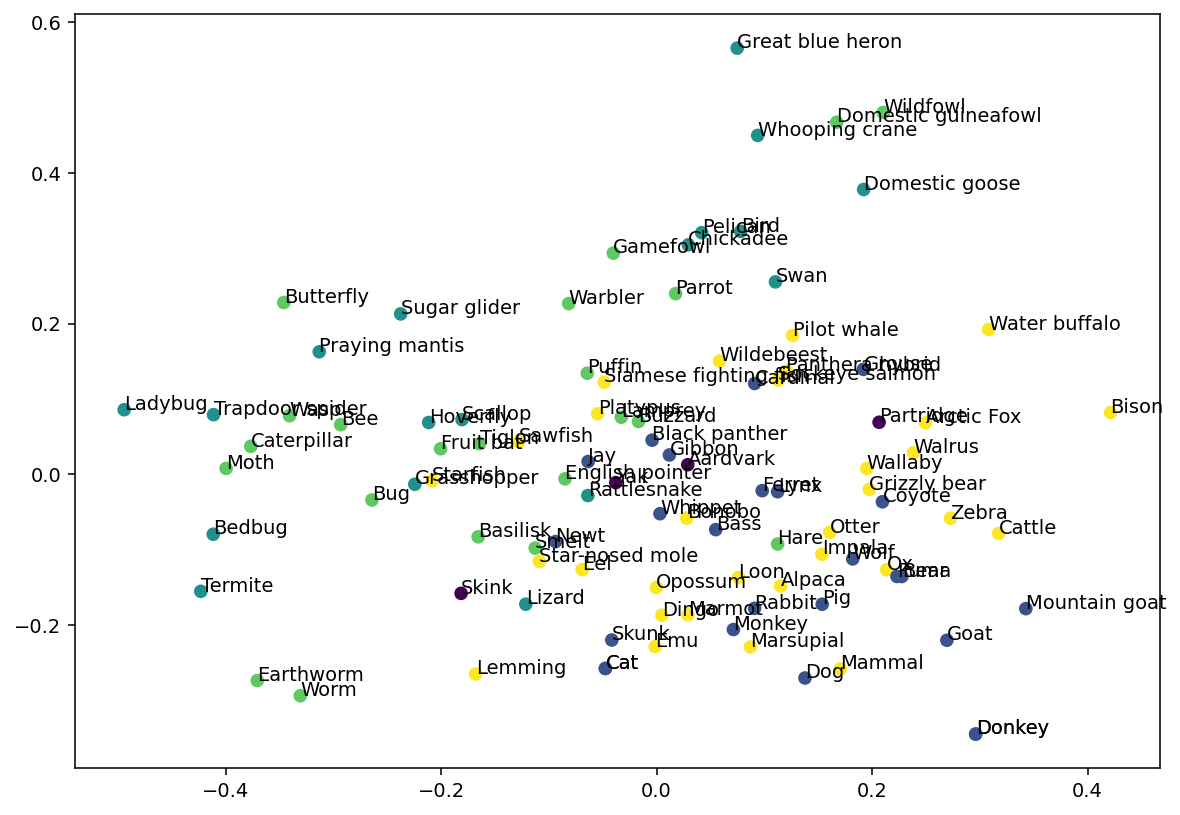

In [13]:
pca = PCA(n_components=2)
animals_space_2d = DataFrame(pca.fit_transform(animals_vectors), index=animals_sample['Animal'], columns=['x', 'y'])
plt.figure(figsize=(10, 7), dpi=140)
plt.scatter(animals_space_2d['x'], animals_space_2d['y'], c=kmeans.labels_)
for i, txt in enumerate(animals_space_2d.index):
    plt.annotate(txt, (animals_space_2d['x'].iloc[i], animals_space_2d['y'].iloc[i]))
plt.show()

In [14]:
text = "This laptop has amazing battery life and runs really fast, but the screen is a bit dim."
text_embedding = model.encode([text])

aspects = ["battery life", "performance", "screen brightness", "kingdom", "animals", "fictional characters"]
aspect_embeddings = model.encode(aspects)

text_embedding = text_embedding.reshape(1, -1) 
aspect_embeddings = aspect_embeddings.reshape(len(aspects), -1)

similarities = cosine_similarity(text_embedding, aspect_embeddings)[0]  

for aspect, similarity in zip(aspects, similarities):
    print(f"Aspect: {aspect}, Relevance: {similarity:.3f}")

Aspect: battery life, Relevance: 0.386
Aspect: performance, Relevance: 0.106
Aspect: screen brightness, Relevance: 0.583
Aspect: kingdom, Relevance: -0.059
Aspect: animals, Relevance: -0.119
Aspect: fictional characters, Relevance: -0.062


In [15]:
abstract_english_words = pd.read_csv("data/abstract_nouns.csv")
abstract_english_words

,word
0,Ability
1,Advantage
2,Adventure
3,Amazement
4,Anger
...,...
194,Wealth
195,Weariness
196,Wisdom
197,Wit


In [16]:
common_english_words_vectors = model.encode(abstract_english_words['word'])


In [17]:
birds

,index,similarity,distance
0,Fancy rat varieties,0.676056,0.323944
1,Buzzard,0.557526,0.442474
2,Cephalopod,0.548795,0.451205
3,Bass,0.533362,0.466638
4,African leopard,0.514671,0.485329
5,Cat,0.478479,0.521521
6,Cat,0.468883,0.531117
7,Barracuda,0.456039,0.543961
8,Catshark,0.452716,0.547284
9,Angelfish,0.452638,0.547362


In [18]:
birds_vectors = model.encode(birds['index'])
birds_centroid = birds_vectors.mean(axis=0).reshape(1, -1)

similarities = cosine_similarity(birds_centroid, common_english_words_vectors)[0]
top_indices = similarities.argsort()[-3:][::-1]
abstract_english_words.iloc[top_indices]


,word
163,Shock
2,Adventure
7,Appetite
